# 5Q) K-Means

In this question we are asked to implement the SLIC (Simple Linear Iterative Clustering) algorithm, which is used for superpixel segementation. SLIC groups pixels into small, uniform regions (superpixels) that have similar color and spatial proximity. It has a basic extension of K-means algorithm. 

In [7]:
import numpy as np
from skimage import color
from skimage.color import label2rgb
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

## 5.1) SLIC
In this part of the question the SLIC (Simpel Linear Iterative Clustering) from scratch.


Testing with 5 iterations...


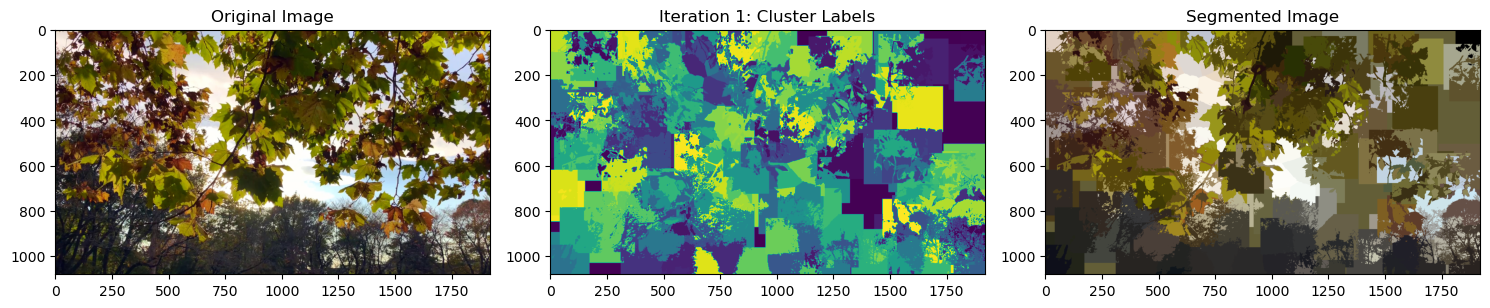

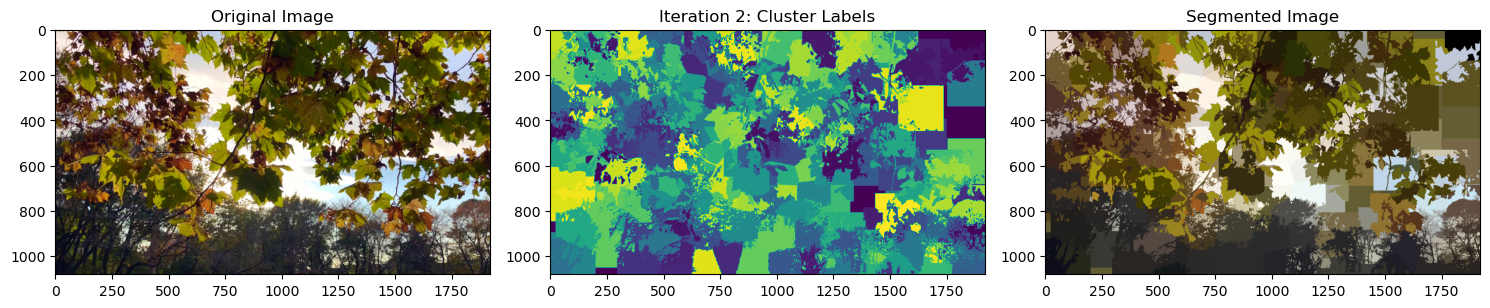

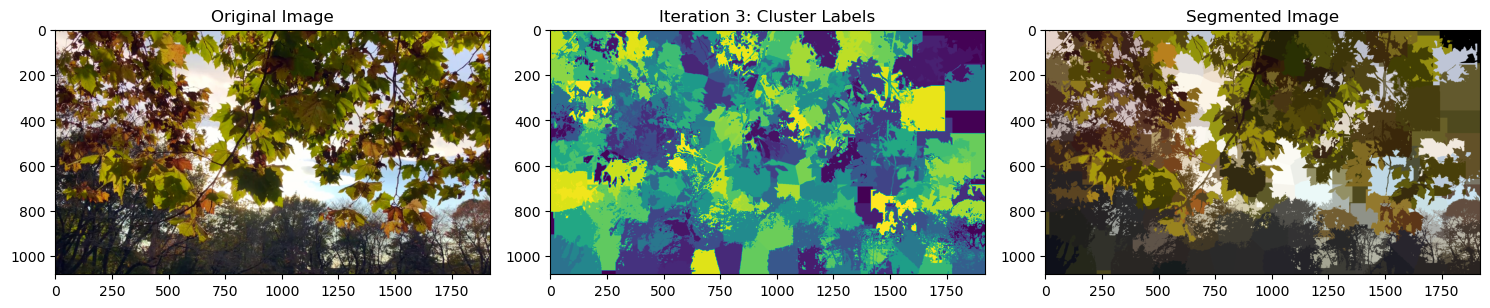

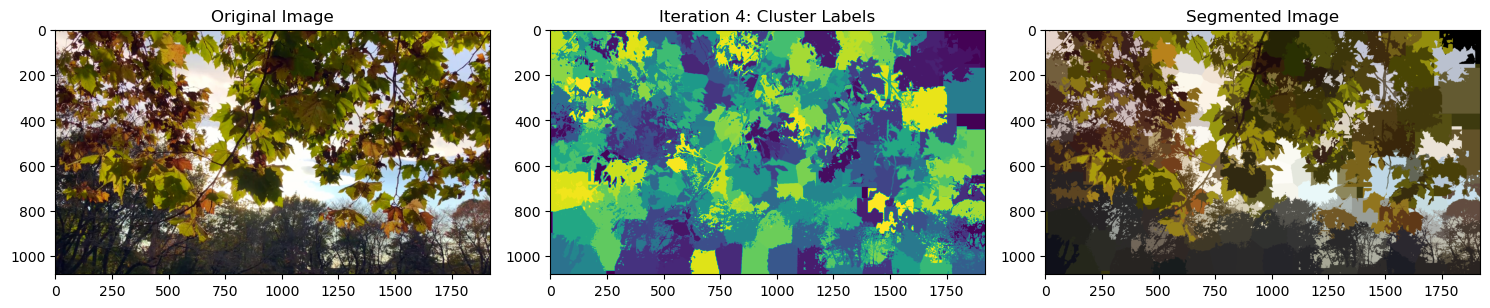

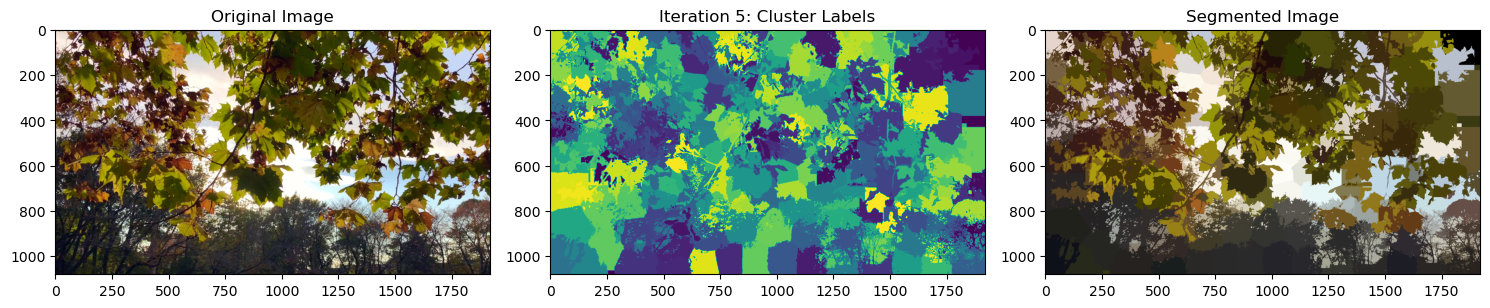

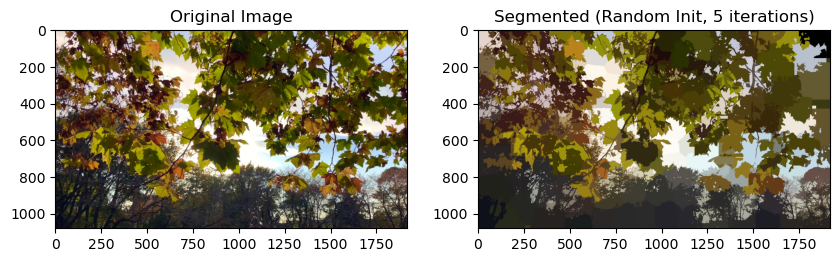

In [10]:
# Function to initialize cluster centers on a regular grid
def initialize_clusters(image, n_segments):
    h, w = image.shape[:2]
    
    # calculating the grid interval
    S = int((h * w / n_segments)**0.5)
    
    # initializing random cluster centers
    x_grid = np.arange(S//2, w, S)
    y_grid = np.arange(S//2, h, S)
    
    cluster_centers = []
    for y in y_grid:
        for x in x_grid:
            if y >= h or x >= w:
                continue
            cluster_centers.append([x, y] + list(image[int(y), int(x)]))
            
    return np.array(cluster_centers), S

# Function to initialize cluster centers randomly across the image
def initialize_clusters_random(image, n_segments):
    h, w = image.shape[:2]
    
    # calcualting cluster
    S = int((h * w / n_segments)**0.5)
    
    # Generate random positions
    x_positions = np.random.randint(0, w, size=n_segments)
    y_positions = np.random.randint(0, h, size=n_segments)
    
    cluster_centers = []
    for x, y in zip(x_positions, y_positions):
        cluster_centers.append([x, y] + list(image[y, x]))
            
    return np.array(cluster_centers), S

def get_gradient(image, x, y):
    """Compute gradient at position (x,y)"""
    if x + 1 >= image.shape[1]:
        x = image.shape[1] - 2
    if y + 1 >= image.shape[0]:
        y = image.shape[0] - 2
        
    gradient_x = np.sum((image[y, x+1] - image[y, x])**2)
    gradient_y = np.sum((image[y+1, x] - image[y, x])**2)
    
    return gradient_x + gradient_y

def move_centers_to_lowest_gradient(image, cluster_centers):
    """Move cluster centers to lowest gradient position in 3x3 neighborhood"""
    for idx, center in enumerate(cluster_centers):
        x, y = int(center[0]), int(center[1])
        
        min_gradient = float('inf')
        new_xy = (x, y)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                new_x, new_y = x + i, y + j
                if 0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]:
                    gradient = get_gradient(image, new_x, new_y)
                    if gradient < min_gradient:
                        min_gradient = gradient
                        new_xy = (new_x, new_y)
        
        cluster_centers[idx][0], cluster_centers[idx][1] = new_xy
        cluster_centers[idx][2:] = image[new_xy[1], new_xy[0]]
    
    return cluster_centers

def assign_pixels(image, cluster_centers, S, compactness):
    """Assign pixels to nearest cluster center"""
    h, w = image.shape[:2]
    distances = np.full((h, w), np.inf)
    labels = np.full((h, w), -1)
    
    for idx, center in enumerate(cluster_centers):
        y_start = max(0, int(center[1] - S))
        y_end = min(h, int(center[1] + S))
        x_start = max(0, int(center[0] - S))
        x_end = min(w, int(center[0] + S))
        
        for y in range(y_start, y_end):
            for x in range(x_start, x_end):
                color_diff = np.sum((image[y, x] - center[2:])**2)
                spatial_diff = (x - center[0])**2 + (y - center[1])**2
                D = (color_diff + (compactness/S)**2 * spatial_diff)**0.5
                
                if D < distances[y, x]:
                    distances[y, x] = D
                    labels[y, x] = idx
    
    return labels, distances

def update_centers(image, labels, cluster_centers):
    """Update cluster centers based on mean of assigned pixels"""
    for idx in range(len(cluster_centers)):
        mask = labels == idx
        if np.any(mask):
            y_indices, x_indices = np.where(mask)
            cluster_centers[idx][0] = np.mean(x_indices)
            cluster_centers[idx][1] = np.mean(y_indices)
            cluster_centers[idx][2:] = np.mean(image[mask], axis=0)
    
    return cluster_centers

def display_current_state(image, labels, iteration, color_space='lab', display_mode='boundaries'):
    """Enhanced display function with multiple visualization options"""
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(131)
    if color_space == 'lab':
        display_img = color.lab2rgb(image)
    else:
        display_img = image
    plt.imshow(display_img)
    plt.title('Original Image')
    
    # Label visualization
    plt.subplot(132)
    plt.imshow(labels, cmap='viridis')
    plt.title(f'Iteration {iteration + 1}: Cluster Labels')
    
    # Segmentation visualization
    plt.subplot(133)
    if display_mode == 'boundaries':
        # Draw boundaries
        boundaries = np.zeros_like(image)
        for y in range(1, image.shape[0]):
            for x in range(1, image.shape[1]):
                if labels[y, x] != labels[y-1, x] or labels[y, x] != labels[y, x-1]:
                    boundaries[y, x] = [1, 1, 1] if color_space == 'rgb' else [100, 0, 0]
        
        if color_space == 'lab':
            display_img = color.lab2rgb(image)
        else:
            display_img = image
        plt.imshow(display_img + boundaries)
        plt.title('Segmentation Boundaries')
    else:
        # Use label2rgb for visualization
        if color_space == 'lab':
            image_rgb = color.lab2rgb(image)
        else:
            image_rgb = image
        segmented_image = label2rgb(labels, image_rgb, kind='avg')
        plt.imshow(segmented_image)
        plt.title('Segmented Image')
    
    plt.tight_layout()
    plt.show()

def slic_segmentation(image, n_segments=100, compactness=10, max_iter=10, 
                     color_space='lab', display_iterations=False, 
                     random_init=False, display_mode='boundaries'):
    """
    Enhanced SLIC segmentation function
    
    Parameters:
    -----------
    image : array_like
        Input image
    n_segments : int
        Number of segments
    compactness : float
        Balances color proximity and space proximity
    max_iter : int
        Number of iterations
    color_space : str
        'lab' or 'rgb'
    display_iterations : bool
        Whether to show intermediate results
    random_init : bool
        Whether to use random initialization
    display_mode : str
        'boundaries' or 'segments' for different visualization styles
    """
    # Convert to LAB color space if specified
    if color_space == 'lab':
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = color.rgb2lab(image)
    
    # Initialize
    if random_init:
        cluster_centers, S = initialize_clusters_random(image, n_segments)
    else:
        cluster_centers, S = initialize_clusters(image, n_segments)
    
    cluster_centers = move_centers_to_lowest_gradient(image, cluster_centers)
    
    # Iterate
    for iteration in range(max_iter):
        labels, distances = assign_pixels(image, cluster_centers, S, compactness)
        if display_iterations:
            display_current_state(image, labels, iteration, color_space, display_mode)
        cluster_centers = update_centers(image, labels, cluster_centers)
    
    return labels, cluster_centers

# Load image
image = cv2.imread("./SMAI A1/frame_0000.jpg")
if image is None:
    raise ValueError("Error: Image not found. Check the file path.")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Try different iterations to find optimal number
iterations_to_try = [5]

for iter_num in iterations_to_try:
    print(f"\nTesting with {iter_num} iterations...")
    
    # With random initialization
    labels_random, _ = slic_segmentation(
        image,
        n_segments=200,
        compactness=20,
        max_iter=iter_num,
        random_init=True,
        display_iterations=True,
        display_mode='segments'  # Try 'boundaries' or 'segments'
    )
    
    # Display final result using label2rgb
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Original Image')
    
    plt.subplot(122)
    segmented = label2rgb(labels_random, image, kind='avg')
    plt.imshow(segmented)
    plt.title(f'Segmented (Random Init, {iter_num} iterations)')
    plt.show()

## 5.2) Video Segmentation with SLC
In this part of the question we are asked to implement the above written SLIC algorithm to perform a frame wise segemntation of the video. Also, we are aksed to get back the video from the frames using the already given code processes.ipynb

In [8]:
# Function to process all frames in a folder using the above written SLIC segmentataion
def process_video_frames(input_folder, output_folder, n_segments=200, compactness=20, max_iter=10, random_init=False):
    os.makedirs(output_folder, exist_ok=True)

    frames = sorted([f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))])

    print(f'Processing {len(frames)} frames..')

    for frame_name in tqdm(frames):
        frame_path = os.path.join(input_folder, frame_name)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        labels, _ = slic_segmentation(
            frame,
            n_segments = n_segments,
            compactness = compactness,
            max_iter = max_iter,
            random_init = random_init,
            display_iterations = False
        )

        segmented = label2rgb(labels, frame, kind='avg')

        segmented_bgr = cv2.cvtColor((segmented*255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        output_path = os.path.join(output_folder, frame_name)
        cv2.imwrite(output_path, segmented_bgr)

def frames_to_video(input_folder, output_path, fps=30):
    """
    Convert a sequence of frames to video
    
    Parameters:
    -----------
    input_folder : str
        Path to folder containing frames
    output_path : str
        Path where the output video will be saved
    fps : int
        Frames per second for the output video
    """
    frames = sorted([f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))])
    
    if not frames:
        print("No frames found in the input folder!")
        return
    
    # Read first frame to get dimensions
    first_frame = cv2.imread(os.path.join(input_folder, frames[0]))
    height, width = first_frame.shape[:2]
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    print("Creating video...")
    
    # Write frames to video
    for frame_name in tqdm(frames):
        frame_path = os.path.join(input_folder, frame_name)
        frame = cv2.imread(frame_path)
        out.write(frame)
    
    out.release()
    print(f"Video saved to {output_path}")

# Folders and paths
input_frames_folder = "./SMAI A1/frames"  # Folder containing original frames
segmented_frames_folder = "./segmented_frames"  # Folder to save segmented frames
output_video_path = "./segmented_video.mp4"  # Path for output video

# Process frames
process_video_frames(
    input_frames_folder,
    segmented_frames_folder,
    n_segments=200,
    compactness=20,
    max_iter=10,
    random_init=False
)

# Create video from processed frames
frames_to_video(segmented_frames_folder, output_video_path, fps=30)

Processing 11 frames..


100%|██████████| 11/11 [1:37:00<00:00, 529.10s/it]


Creating video...


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

Video saved to ./segmented_video.mp4


## 5.3) Optimizing the video segmentation
In 

In [ ]:
import time

def process_video_frames_optimized(input_folder, output_folder, n_segments=200, 
                                 compactness=20, max_iter=10, convergence_threshold=0.01):
    """
    Process frames with temporal optimization
    """
    os.makedirs(output_folder, exist_ok=True)
    frames = sorted([f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))])
    
    # Statistics for analysis
    iterations_used = []
    processing_times = []
    previous_centers = None
    
    print(f"Processing {len(frames)} frames with optimization...")
    
    for frame_idx, frame_name in enumerate(tqdm(frames)):
        start_time = time()
        
        # Read frame
        frame_path = os.path.join(input_folder, frame_name)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to LAB color space
        frame_lab = color.rgb2lab(frame)
        
        if frame_idx == 0:
            # First frame: normal SLIC
            labels, centers = slic_segmentation(
                frame_lab,
                n_segments=n_segments,
                compactness=compactness,
                max_iter=max_iter,
                random_init=False,
                display_iterations=False
            )
            iterations_used.append(max_iter)
            previous_centers = centers
            
        else:
            # Subsequent frames: use previous centers as initialization
            labels, centers, iters = slic_segmentation_with_previous(
                frame_lab,
                previous_centers,
                compactness=compactness,
                max_iter=max_iter,
                convergence_threshold=convergence_threshold
            )
            iterations_used.append(iters)
            previous_centers = centers
        
        # Convert segmentation to RGB image
        segmented = label2rgb(labels, frame, kind='avg')
        segmented_bgr = cv2.cvtColor((segmented * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        
        # Save segmented frame
        output_path = os.path.join(output_folder, frame_name)
        cv2.imwrite(output_path, segmented_bgr)
        
        processing_times.append(time() - start_time)
    
    return {
        'avg_iterations': np.mean(iterations_used),
        'avg_time_per_frame': np.mean(processing_times),
        'total_frames': len(frames)
    }

def slic_segmentation_with_previous(image, previous_centers, compactness=10, 
                                  max_iter=10, convergence_threshold=0.01):
    """
    SLIC segmentation using previous frame's centers as initialization
    """
    cluster_centers = previous_centers.copy()
    h, w = image.shape[:2]
    S = int((h * w / len(cluster_centers))**0.5)
    
    # Initialize with previous centers
    cluster_centers = move_centers_to_lowest_gradient(image, cluster_centers)
    
    prev_labels = None
    for iteration in range(max_iter):
        # Assign pixels
        labels, distances = assign_pixels(image, cluster_centers, S, compactness)
        
        # Check convergence
        if prev_labels is not None:
            change = np.mean(labels != prev_labels)
            if change < convergence_threshold:
                return labels, cluster_centers, iteration + 1
        
        prev_labels = labels.copy()
        cluster_centers = update_centers(image, labels, cluster_centers)
    
    return labels, cluster_centers, max_iter

def compare_methods(input_folder, n_segments=200, compactness=20, max_iter=10):
    """
    Compare original and optimized methods
    """
    print("Running original method...")
    start_time = time.time()  # <-- FIXED
    stats_original = process_video_frames(
        input_folder,
        "./segmented_frames_original",
        n_segments=n_segments,
        compactness=compactness,
        max_iter=max_iter
    )
    original_time = time.time() - start_time  # <-- FIXED
    
    print("\nRunning optimized method...")
    start_time = time.time()  # <-- FIXED
    stats_optimized = process_video_frames_optimized(
        input_folder,
        "./segmented_frames_optimized",
        n_segments=n_segments,
        compactness=compactness,
        max_iter=max_iter
    )
    optimized_time = time.time() - start_time  # <-- FIXED
    
    print("\nComparison Results:")
    print(f"Original Method:")
    print(f"- Average iterations per frame: {max_iter}")
    print(f"- Total processing time: {original_time:.2f} seconds")
    
    print(f"\nOptimized Method:")
    print(f"- Average iterations per frame: {stats_optimized['avg_iterations']:.2f}")
    print(f"- Total processing time: {optimized_time:.2f} seconds")
    print(f"- Speed improvement: {(original_time/optimized_time):.2f}x")


input_frames_folder = "./SMAI A1/frames"
    
# Run comparison
compare_methods(
    input_frames_folder,
    n_segments=200,
    compactness=20,
    max_iter=10
)

# Create videos from both methods
frames_to_video("./segmented_frames_original", "./segmented_video_original.mp4")
frames_to_video("./segmented_frames_optimized", "./segmented_video_optimized.mp4")

Running original method...
Processing 11 frames..


100%|██████████| 11/11 [1:54:15<00:00, 623.19s/it]



Running optimized method...
Processing 11 frames with optimization...


  0%|          | 0/11 [00:00<?, ?it/s]


TypeError: 'module' object is not callable